## Predict Parkinson's Disease from DEGs

### Background
Using microarray transcriptomic data ([GSE7621](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE7621)), we identified 20 differentially expressed genes (DEGs) through `limma` analysis. The dataset consists of 9 normal samples and 16 Parkinson's disease (PD) patient samples. We aim to employ these 20 DEGs along with patient labels (Normal vs PD) to develop machine learning models for disease prediction.

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import LeaveOneOut, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score)
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

# Load dataset
df = pd.read_csv("final_expr_df.csv", index_col=0)
df.head()

,SLC18A2,UNC13C,GAS1,AGTR1,SLC18A2.1,SLC6A3,TH,RBM3,DNAJB6,DLK1,...,JMJD6,CDH8,THAP2,PPP4R2,EBF3,CASTOR3P,P2RX7,LINC01549,SV2C,label
GSM184354,5.387980,6.317415,4.772732,5.651620,8.864810,8.170089,6.524368,7.290020,6.363752,5.629272,...,5.697295,6.014589,4.063184,6.570137,5.317526,6.902920,8.005512,6.926628,6.535510,Normal
GSM184355,5.752753,3.625257,6.256313,3.542877,7.220538,6.748936,5.538375,6.867178,5.742678,5.813135,...,5.099691,6.379104,3.866769,6.627341,5.320061,6.825455,8.588078,6.136401,6.682633,Normal
GSM184356,8.519943,7.096227,4.912502,6.669122,10.379606,9.894145,9.198448,7.359103,5.620280,7.328322,...,5.315351,6.804868,4.263427,7.189438,7.101658,7.695277,8.053931,5.139333,8.549980,Normal
GSM184357,6.747312,5.527567,4.254670,5.191575,8.892777,7.772563,7.090749,8.392044,5.149172,5.506666,...,4.434592,4.907418,2.901576,4.612783,5.321197,6.869969,7.631683,4.623748,6.472838,Normal
GSM184358,3.912634,4.722793,5.430610,3.211025,5.888305,6.930421,5.743301,7.282789,5.043424,4.037464,...,5.157225,4.671783,3.270034,6.031642,4.442123,7.623871,7.816537,6.269742,5.205024,Normal


In [2]:
# Shuffle the order of data
df = df.sample(frac=1, random_state=42)
df.head()

,SLC18A2,UNC13C,GAS1,AGTR1,SLC18A2.1,SLC6A3,TH,RBM3,DNAJB6,DLK1,...,JMJD6,CDH8,THAP2,PPP4R2,EBF3,CASTOR3P,P2RX7,LINC01549,SV2C,label
GSM184362,8.330465,7.913947,4.976776,7.492751,10.899097,10.558519,9.980838,6.594407,5.885794,7.875741,...,4.965958,7.045733,3.522374,6.063770,7.497650,7.590448,7.657376,6.084075,9.154814,Normal
GSM184370,4.150630,2.494376,6.081750,3.198124,4.901471,5.260781,4.067793,2.734838,7.146876,4.006743,...,6.867958,4.784405,5.185480,7.452546,4.542985,5.414278,9.925487,4.555662,4.782895,PD
GSM184354,5.387980,6.317415,4.772732,5.651620,8.864810,8.170089,6.524368,7.290020,6.363752,5.629272,...,5.697295,6.014589,4.063184,6.570137,5.317526,6.902920,8.005512,6.926628,6.535510,Normal
GSM184377,3.858706,2.579279,6.501746,3.042608,5.454190,6.268051,3.302302,3.412292,6.904367,3.634548,...,6.624421,4.517293,4.840521,7.830508,4.142135,5.713661,9.906456,4.605680,4.883237,PD
GSM184365,3.931092,2.935204,5.652252,3.134653,5.495611,6.138254,4.567920,4.284567,6.173025,4.420545,...,5.954373,3.655824,4.854424,7.196322,4.150174,6.055767,9.348037,4.608623,4.518201,PD


In [3]:
df.describe()

,SLC18A2,UNC13C,GAS1,AGTR1,SLC18A2.1,SLC6A3,TH,RBM3,DNAJB6,DLK1,ALDH1A1,JMJD6,CDH8,THAP2,PPP4R2,EBF3,CASTOR3P,P2RX7,LINC01549,SV2C
count,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000
mean,5.179955,4.659420,5.864420,4.044264,7.283097,7.307248,5.977138,4.936946,6.500905,5.085255,8.535309,5.885133,5.107096,4.350996,6.931863,5.133739,6.563666,8.584285,4.922539,6.222105
std,1.574840,1.796508,0.685968,1.447551,2.047561,1.793256,2.098741,1.831940,0.837860,1.359865,1.431737,0.754885,1.038672,0.703425,0.766498,1.069036,0.694399,0.716661,0.982665,1.380335
min,3.700521,2.494376,4.254670,2.992370,4.514594,4.360904,2.800120,2.734838,5.043424,3.586063,6.097612,4.434592,3.492443,2.901576,4.612783,3.932140,5.092125,7.435786,3.329746,4.518201
25%,4.016568,2.992425,5.430610,3.196329,5.611783,6.003159,4.550447,3.199989,5.817433,4.037464,7.733931,5.315351,4.478158,3.830578,6.570137,4.284441,6.059464,8.005512,4.354134,5.205024
50%,4.521206,4.219435,6.081750,3.371986,6.456680,6.748936,6.050174,4.440379,6.363752,4.572925,8.384064,5.927773,4.784405,4.410094,7.060004,4.916765,6.576263,8.588078,4.623748,5.947832
75%,5.763829,6.113408,6.278645,4.105011,8.864810,8.327744,7.090749,6.594407,7.146876,5.813135,9.005453,6.434947,5.802024,4.853522,7.452546,5.321197,6.902920,9.077487,5.395596,6.920510
max,9.299166,8.360138,7.115638,8.017130,11.426153,10.960251,10.174961,8.392044,8.138199,8.579259,12.024615,7.076736,7.561556,5.663914,8.107638,7.601228,7.695277,9.925487,6.926628,9.701639


### Data Preprocessing

In [4]:
X = df.drop(columns=["label"])
y = df["label"]

# Convert Label into 0 (normal) and 1 (PD)
encoder = LabelEncoder()
y = encoder.fit_transform(y)

# Standardize all features X
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) 

### Define models. Leave One Out vs. Cross Validation

Given the small dataset size, considering use either **LOOCV (Leave-One-Out Cross-Validation)** or **k-fold** cross-validation (e.g., 5 or 10-fold):

- **LOOCV**: In each iteration, one sample is left out for testing, and the remaining 24 samples are used for training. This maximizes the number of training samples.

- **k-fold CV**: For example, in 5-fold CV, the 25 samples are divided into 5 folds, with each fold taking turns as the test set while the rest are used for training.

In [5]:
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42), # max_iter: avoid convergence warning
    "LDA": LinearDiscriminantAnalysis(),
    "QDA": QuadraticDiscriminantAnalysis(), 
    "SVM": SVC(kernel= 'linear', probability=True,random_state=42)
}

loo = LeaveOneOut()
results = {}
for model_name, model in models.items():
    scores = cross_val_score(model, X_scaled, y, cv=loo, scoring='accuracy')
    results[model_name] = (scores.mean(), scores.std())

# Print out the results
print("Leave One Out")
for model_name, (mean_acc, std_acc) in results.items():
    print(f"{model_name}: Mean Accuracy = {mean_acc: .3f} (std={std_acc:.3f})")

print("======================================================================")
print("Cross Validation")

## Cross Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) 
for model_name, model in models.items():
    scores = cross_val_score(model, X_scaled, y, cv=cv, scoring='accuracy')
    results[model_name] = (scores.mean(), scores.std())

# Print out the results
for model_name, (mean_acc, std_acc) in results.items():
    print(f"{model_name}: Mean Accuracy = {mean_acc: .3f} (std={std_acc:.3f})")

Leave One Out
LogisticRegression: Mean Accuracy =  0.920 (std=0.271)
LDA: Mean Accuracy =  0.440 (std=0.496)
QDA: Mean Accuracy =  0.720 (std=0.449)
SVM: Mean Accuracy =  0.800 (std=0.400)
Cross Validation
LogisticRegression: Mean Accuracy =  0.880 (std=0.160)
LDA: Mean Accuracy =  0.720 (std=0.160)
QDA: Mean Accuracy =  0.680 (std=0.160)
SVM: Mean Accuracy =  0.800 (std=0.179)


#### Key Insights

Logistic Regression has higher accuracy using either LOOCV or 5-Fold CV.

**1. LOOCV (0.920 ± 0.271)**

- LOOCV achieves a high mean accuracy of 92%, indicating strong model performance.

- The larger standard deviation (0.271) reflects sensitivity to individual samples, which is expected due to testing on a single sample each iteration.

- Despite variability, the high accuracy confirms the discriminative power of the 20 DEGs.

**2. 5-Fold CV (0.880 ± 0.160)**

- Logistic Regression achieves 88% mean accuracy, demonstrating robust generalization.

- The smaller standard deviation (0.160) suggests more stable performance compared to LOOCV.

- Accuracy remains well above random guessing (expected ~0.5-0.64), confirming the predictive relevance of the DEGs.

#### Interpretation
- **DEGs Predictive Power**: The 20 DEGs effectively capture differences between normal and PD samples, as evidenced by the high accuracy.

- **No Overfitting**: The model generalizes well, with cross-validation accuracy (88%) significantly lower than training accuracy (1.0).

- **Feasibility**: The results validate the feasibility of using DEGs for PD prediction, even with a small dataset (n=25).

#### Comparison: LOOCV vs. 5-Fold CV
- **LOOCV**: Suitable for small datasets but less stable due to high variance (std = 0.271).

- **5-Fold CV**: More reliable for generalization assessment, with lower variance (std = 0.160) and better computational efficiency.

- **Conclusion**: 5-Fold CV is preferred for its balance between data utilization and stability, providing a more realistic estimate of model performance.

### Compare AUC-ROC, F1, Precision, Recall: Logistric Regression vs. SVM

In [6]:
# CV k-fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define LR, SVM model with default parameters
lr = LogisticRegression(random_state=42, max_iter=1000)
svm = SVC(kernel= 'linear', probability=True,random_state=42)  # AUC needs: probability=True

models = {
    "LogisticRegression": lr,
    "SVM": svm
}

for model_name, model in models.items():
    # Get the label and probability of cross_val_predict 
    y_pred = cross_val_predict(model, X_scaled, y, cv=cv, method='predict')
    y_prob = cross_val_predict(model, X_scaled, y, cv=cv, method='predict_proba')[:, 1]
    
    acc = accuracy_score(y, y_pred)
    prec = precision_score(y, y_pred)
    rec = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    auc = roc_auc_score(y, y_prob)
    
    print(f"{model_name} - (No fine-tune) 5-fold CV metrics:")
    print(f"  Accuracy:  {acc:.3f}")
    print(f"  Precision: {prec:.3f}")
    print(f"  Recall:    {rec:.3f}")
    print(f"  F1-score:  {f1:.3f}")
    print(f"  AUC:       {auc:.3f}")
    print("----------------------------------------------------")

LogisticRegression - (No fine-tune) 5-fold CV metrics:
  Accuracy:  0.880
  Precision: 0.882
  Recall:    0.938
  F1-score:  0.909
  AUC:       0.958
----------------------------------------------------
SVM - (No fine-tune) 5-fold CV metrics:
  Accuracy:  0.800
  Precision: 0.824
  Recall:    0.875
  F1-score:  0.848
  AUC:       0.951
----------------------------------------------------


### Comparison: Logistic Regression vs. SVM
**1. Performance Metrics**

- LR slightly outperforms SVM in **Accuracy, Precision, Recall, F1-score and AUC**, indicating better classification performance in these metrics under 5-fold cross-validation.

- LR achieves the higher **Recall (0.938)**, demonstrating strong sensitivity in identifying positive (PD) samples. We choose LR for fine-tuning parameters.

**2. Small Sample Size Considerations**

- With only 25 samples and 5-fold cross-validation, the observed differences in metrics are likely within the margin of error. Further validation is recommended to confirm these results.

#### Next Steps

**1. Hyperparameter Tuning**

- **Logistic Regression**: Optimize parameters (eg., GridSearchCV) such as `penalty` (l1, l2), `C` (regularization strength), and `solver` (e.g., 'liblinear', 'saga').

- If recall (sensitivity) is critical (e.g., to minimize missed PD diagnoses), prioritize tuning for this metric.

**2. Rigorous Evaluation Methods**

- **Nested Cross-Validation**: Use outer CV for final evaluation and inner CV for hyperparameter search to avoid optimistic bias. However, with only 25 samples, nested CV may increase variability due to smaller data splits.

- **Statistical Tests**: Use McNemar’s test for Accuracy or DeLong’s test for AUC to assess if differences between models are statistically significant. Note that statistical power may be limited with small sample sizes.

**3. Model Interpretability and Biological Relevance**

- **Logistic Regression**: Provides interpretable coefficients, allowing identification of key DEGs contributing to PD classification.


### Fine-Tune Parameters (GridSearchCV) for Logistic Regression


In [14]:
# Define scoring metrics
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

# 1. Search parameters for Logistic Regression 
lr_param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear']  # Support L1 penalty
}

# Set uup GridSearchCV
lr_grid_search = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=42),
    param_grid=lr_param_grid,
    scoring=scoring,  
    refit='f1',  # choose the primary metrics to get best_params_
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1,
    return_train_score=True  
)

lr_grid_search.fit(X_scaled, y)

# Print out the best parameters and best score of the primary metrics
print("LR Best Params:", lr_grid_search.best_params_)
print("LR Best Accuracy (primary metric):", lr_grid_search.best_score_)

# Check all metrics results
cv_results = pd.DataFrame(lr_grid_search.cv_results_)
metrics = ['mean_test_accuracy',
           'mean_test_precision',
           'mean_test_recall',
           'mean_test_f1', 
           'mean_test_roc_auc']

print("\nLogistic Regression CV Results (mean scores):")
print(cv_results[
      metrics + ['param_penalty', 'param_C', 'param_solver']
      ].sort_values('mean_test_f1', ascending=False).head())

# Obtain the best model
best_lr = lr_grid_search.best_estimator_



LR Best Params: {'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'}
LR Best Accuracy (primary metric): 0.9314285714285713

Logistic Regression CV Results (mean scores):
   mean_test_accuracy  mean_test_precision  mean_test_recall  mean_test_f1  \
1                0.92                 1.00          0.883333      0.931429   
3                0.92                 1.00          0.883333      0.931429   
5                0.92                 1.00          0.883333      0.931429   
7                0.84                 0.92          0.900000      0.883333   
9                0.84                 0.92          0.900000      0.883333   

   mean_test_roc_auc param_penalty param_C param_solver  
1                1.0            l2   0.001    liblinear  
3                1.0            l2    0.01    liblinear  
5                1.0            l2     0.1    liblinear  
7                1.0            l2       1    liblinear  
9                1.0            l2      10    liblinear  


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Librar

The F1-score is the harmonic mean of Precision and Recall. F1-score is used balance both Precision and Recall simultaneously.




In [17]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(best_lr, X_scaled, y, cv=cv, scoring='f1')

print(f"Best Model: 5-fold CV F1 Score: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

Best Model: 5-fold CV F1 Score: 0.931 ± 0.086


In [18]:
y_pred = best_lr.predict(X_scaled)

# confusion matrix
conf_matrix = confusion_matrix(y, y_pred)

# classification report
class_report = classification_report(y, y_pred)

print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)


Confusion Matrix:
 [[ 9  0]
 [ 2 14]]
Classification Report:
               precision    recall  f1-score   support

           0       0.82      1.00      0.90         9
           1       1.00      0.88      0.93        16

    accuracy                           0.92        25
   macro avg       0.91      0.94      0.92        25
weighted avg       0.93      0.92      0.92        25



- TN=9 (True Negative, Normal)
- FP=0 (False Positive, 0 normal people were diagnosed with PD)
- FN=2 (False Negative, 2 PD patients were diagnosed with normal)
- TP=14 (True Postive, 14 PD patients with correctly diagnosed with PD)

#### ROC curve & Precision-Recall (PR) curve

- **ROC-AUC**: Measures overall classification performance.  
- **PR-AUC**: More informative for imbalanced datasets (e.g., fewer PD samples).  

#### Interpretation
- **AUC ≈ 1.0**: Excellent model performance.  
- **AUC < 0.8**: Room for improvement.  

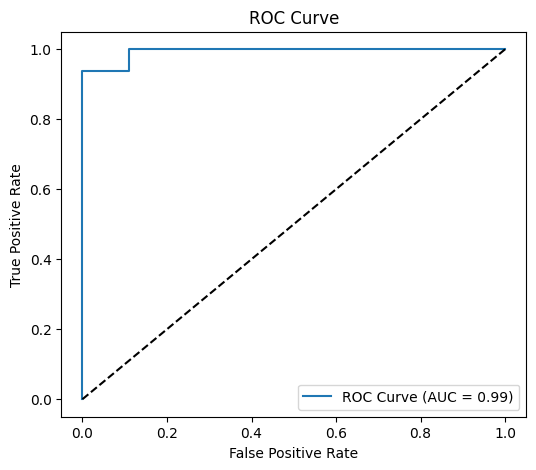

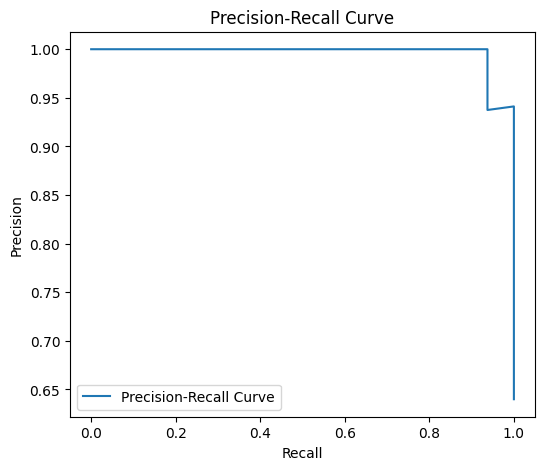

In [21]:
from sklearn.metrics import roc_curve, auc

# Get predicted probability
y_prob = best_lr.predict_proba(X_scaled)[:, 1]

# ROC curve
fpr, tpr, _ = roc_curve(y, y_prob)

# auc_score = auc(fpr, tpr)  # 使用不同變數名稱

roc_auc_score = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Baseline by random guess
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Precision-Recall curve
precision, recall, _ = precision_recall_curve(y, y_prob)
plt.figure(figsize=(6, 5))
plt.plot(recall, precision, label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()


#### Potential Overfitting
- **Small Sample Size (e.g., n=25)**: Even if the model performs perfectly, it might learn non-generalizable patterns due to limited data.  
  - Example: If only 16 PD samples are used, AUC≈1.0 might result from small data size, not true generalizability.  
  - **Solution**: Use external validation or Nested Cross-Validation (Nested CV) to verify.  

#### High Discriminative Power of Data
- If the selected DEGs strongly distinguish PD vs. Normal, AUC≈1.0 might be valid.  
  - Check **feature distribution** (DEG values between PD and Normal). If DEGs show clear separation, AUC≈1.0 could be reasonable.  


### Correlation Coefficient for Feature Importance

In logistic regression, the **coefficients** indicate how much the log-odds of the target class (e.g., PD) change for a one-unit increase in the feature value. A positive coefficient means the feature is positively correlated with the target class (PD), while a negative coefficient means it is negatively correlated. The magnitude of the coefficient reflects the importance of the feature in predicting the target. Larger coefficients indicate stronger influence.

By sorting the coefficients, we can identify the top features (genes) that contribute most to the model's predictions.

In [22]:
# Feature Importance
coefs = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": best_lr.coef_[0]
})
print("\nFeature Importance (Coefficients):")
print(coefs.sort_values(by="Coefficient", ascending=False))


Feature Importance (Coefficients):
      Feature  Coefficient
2        GAS1     0.008707
17      P2RX7     0.008137
8      DNAJB6     0.008116
13      THAP2     0.008057
14     PPP4R2     0.007637
11      JMJD6     0.007311
19       SV2C    -0.007249
10    ALDH1A1    -0.007291
15       EBF3    -0.007370
6          TH    -0.007398
5      SLC6A3    -0.007399
1      UNC13C    -0.007542
4   SLC18A2.1    -0.007730
12       CDH8    -0.007769
9        DLK1    -0.007814
18  LINC01549    -0.007861
0     SLC18A2    -0.007966
3       AGTR1    -0.007990
7        RBM3    -0.008175
16   CASTOR3P    -0.008372


The top 5 genes related to PD are GAS1, P2RX7, DNAJB6, THAP2, and PPP4R2. These genes are involved in neuroinflammtory response (P2RX7), neuroprotection (GAS1), and peptide-binding chaperon (DNAJB6). Further investigation can be conducted from these genes.